In [1]:
#!/usr/bin/python
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import scipy.misc
import time
import argparse
import sys
import cv2
from multiprocessing import Process
from multiprocessing.queues import Queue

caffe_root = '/home/osboxes/caffe'


sys.path.insert(0, os.path.join(caffe_root , 'python'))
import caffe

In [2]:
#this window size needs to be exactly the same size as that used to extract the patches from the matlab version
wsize = 32
hwsize= int(wsize/2)

BASE='/home/osboxes/docmac/TrainingTissueFinder/DL_DIGITALPATHOLOGY/DL_DigitalPathology/DL_tutorial_Code/case4_lymphocyte'
FOLD=2

#Locations of the necessary files are all assumed to be in subdirectoires of the base file
MODEL_DIR   = os.path.join(BASE,'models')
COMMON_DIR  = os.path.join('/home/osboxes/docmac/TrainingTissueFinder/DL_DIGITALPATHOLOGY/DL_DigitalPathology/DL_tutorial_Code/','common')

MODEL_FILE = os.path.join(COMMON_DIR,'deploy_train32.prototxt')
PRETRAINED = '%s/models/%d_caffenet_train_w32_iter_600000.caffemodel' % (BASE,FOLD)
IMAGE_DIR= '%s/images/' % BASE
OUTPUT_DIR= '%s/images/%d/' % (BASE,FOLD)

In [3]:
OUTPUT_DIR

'/home/osboxes/docmac/TrainingTissueFinder/DL_DIGITALPATHOLOGY/DL_DigitalPathology/DL_tutorial_Code/case4_lymphocyte/images/2/'

In [4]:
#if our output directory doesn't exist, lets create it. each fold gets a numbered directory inside of the image directory
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
#load our mean file and reshape it accordingly
a = caffe.io.caffe_pb2.BlobProto()
file = open('%s/DB_train_w32_%d.binaryproto' % (MODEL_DIR,FOLD) ,'rb')
data = file.read()
a.ParseFromString(data)
means = a.data
means = np.asarray(means)
means = means.reshape(3, 32, 32)


In [6]:
#make sure we use teh GPU otherwise things will take a very long time
#caffe.set_mode_gpu()
caffe.set_mode_cpu()
#load the model
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=means,
                       channel_swap=(2, 1, 0),
                       raw_scale=255,
                       image_dims=(32, 32))

#see which files we need to produce output for in this fold
#we look at the parent IDs in the test file and only compute those images
#as they've been "held out" from the training set
#files=open('%s/test_w32_parent_%d.txt'%(COMMON_DIR,FOLD),'rb')

start_time = time.time()
start_time_iter=0

#go into the image directory so we can use glob a bit easier
os.chdir(IMAGE_DIR)


(232, 232, 3)


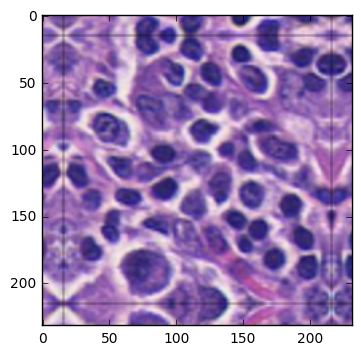

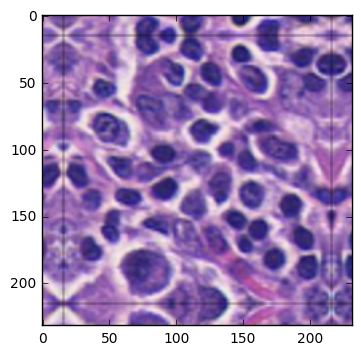

In [12]:
## One image test version

testDataDir = 'HER2/lymphocyte/data'
fname = os.path.join(BASE,testDataDir,'im41.tif')

newfname_class = fname.replace('.tif','_class.tif') #create the new files
newfname_prob = fname.replace('.tif','_prob.tif') #create the new files

outputimage = np.zeros(shape=(10, 10))
#first thing we do is save a file to let potential other workers know that this 
#file is being worked on and it should be skipped
scipy.misc.imsave(newfname_class, outputimage)

image = caffe.io.load_image(fname) #load our image
image = caffe.io.resize_image(image, [image.shape[0]*2,image.shape[1]*2]) #if you need to resize or crop, do it here
image = np.lib.pad(image, ((hwsize, hwsize), (hwsize, hwsize), (0, 0)), 'symmetric') #mirror the edges so that we can compute the full image
imageShape = image.shape
#image = cv2.resize(image,(imageShape[0]*4,imageShape[1]*4), interpolation = cv2.INTER_CUBIC)
imageFull = image
#image = image[0:140,0:150,0:3]

plt.imshow(image)
print image.shape
plt.show()
plt.imshow(imageFull)
plt.show()

In [13]:
outputimage_probs = np.zeros(shape=(image.shape[0],image.shape[1],3)) #make the output files where we'll store the data
outputimage_class = np.zeros(shape=(image.shape[0],image.shape[1]))

for rowi in xrange(hwsize+1,image.shape[0]-hwsize):
	#print "%s\t (%.3f,%.3f)\t %d of %d" % (fname,time.time()-start_time,time.time()-start_time_iter,rowi,image.shape[0]-hwsize)
	start_time_iter = time.time()
	patches=[] #create a set of patches, oeprate on a per column basis
	for coli in xrange(hwsize+1,image.shape[1]-hwsize):
		patches.append(image[rowi-hwsize:rowi+hwsize, coli-hwsize:coli+hwsize,:])

	prediction = net.predict(patches) #predict the output 
	pclass = prediction.argmax(axis=1) #get the argmax
	outputimage_probs[rowi,hwsize+1:image.shape[1]-hwsize,0:2]=prediction #save the results to our output images
	outputimage_class[rowi,hwsize+1:image.shape[1]-hwsize]=pclass


outputimage_probs = outputimage_probs[hwsize:-hwsize, hwsize:-hwsize, :] #remove the edge padding
outputimage_class = outputimage_class[hwsize:-hwsize, hwsize:-hwsize]

scipy.misc.imsave(newfname_prob,outputimage_probs) #save the files
scipy.misc.imsave(newfname_class,outputimage_class)

In [9]:
512/64.0

8.0

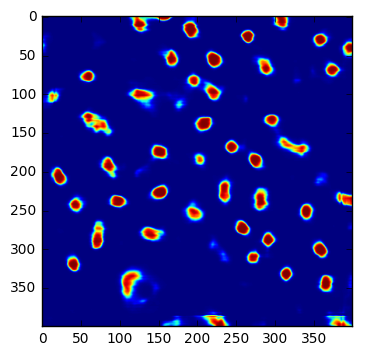

In [10]:
plt.imshow(outputimage_probs[:,:,1])
plt.show()

In [11]:
import numpy as np

def simulateForLoop(rowi):
    	#print "%s\t (%.3f,%.3f)\t %d of %d" % (fname,time.time()-start_time,time.time()-start_time_iter,rowi,image.shape[0]-hwsize)
	start_time_iter = time.time()
	patches=[] #create a set of patches, oeprate on a per column basis
	for coli in xrange(hwsize+1,image.shape[1]-hwsize):
		patches.append(image[rowi-hwsize:rowi+hwsize, coli-hwsize:coli+hwsize,:])

	prediction = net.predict(patches) #predict the output 
	pclass = prediction.argmax(axis=1) #get the argmax
	outputimage_probs[rowi,hwsize+1:image.shape[1]-hwsize,0:2]=prediction #save the results to our output images
	outputimage_class[rowi,hwsize+1:image.shape[1]-hwsize]=pclass

In [ ]:
CORES=8
results = []
queues = [Queue() for i in range(CORES)]
args = [(rowi) for rowi in xrange(hwsize+1,image.shape[0]-hwsize)]
jobs = [Process(target=simulateForLoop, args=(a)) for a in args]

for j in jobs: j.start()
#for q in ques: results.append(q.get())
for j in jobs: j.join()
#S = np.hstack(results)